In [154]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import datetime as dt
import calendar,warnings,itertools,matplotlib,keras,shutil
import tensorflow as tf
import statsmodels.api as sm
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor,BaggingClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from sklearn.datasets import load_iris,make_regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_ridge import KernelRidge
from keras import Sequential
from keras.layers import Dense
from IPython.core import display as ICD
from lightgbm import LGBMRegressor, LGBMClassifier
from imblearn.over_sampling import SMOTE

# from tensorflow_core.estimator import inputs

#Hiding the warnings
warnings.filterwarnings('ignore') 

### Load dataset

In [155]:
path_to_dataset = '/Users/mihaithpc/Desktop/Europe_Datathon/'
df = pd.read_csv(path_to_dataset + "DataAfterFE_310_3.csv", index_col=[0])

le = preprocessing.LabelEncoder()
df['Category Name']  = le.fit_transform(df['Category Name'])
df['Department Name']  = le.fit_transform(df['Department Name'])
df['Order Country']  = le.fit_transform(df['Order Country'])
df['Customer Full Name']  = le.fit_transform(df['Customer Full Name'])
df['Customer State']  = le.fit_transform(df['Customer State'])
df['Customer Country']  = le.fit_transform(df['Customer Country'])
df['Customer City']  = le.fit_transform(df['Customer City'])
#X['Order Status']  = le.fit_transform(X['Order Status'])
df['Order Region']  = le.fit_transform(df['Order Region'])
df['Order State']  = le.fit_transform(df['Order State'])
df['Order City']  = le.fit_transform(df['Order City'])


# Target: Order Profit, delay days explains it well

###
[1]	valid_0's l2: 9360.64
[2]	valid_0's l2: 9346.56
[3]	valid_0's l2: 9335.64
[4]	valid_0's l2: 9324.14
[5]	valid_0's l2: 9315.77
[6]	valid_0's l2: 9308.11
[7]	valid_0's l2: 9301.8
[8]	valid_0's l2: 9297.56
[9]	valid_0's l2: 9294.77
[10]	valid_0's l2: 9291.75
[11]	valid_0's l2: 9289.46
[12]	valid_0's l2: 9291.93
[13]	valid_0's l2: 9290.62
[14]	valid_0's l2: 9288.97
[15]	valid_0's l2: 9287.17
[16]	valid_0's l2: 9284.94
[17]	valid_0's l2: 9284.2
[18]	valid_0's l2: 9284
[19]	valid_0's l2: 9285.45
[20]	valid_0's l2: 9285.2
[21]	valid_0's l2: 9285.65
[22]	valid_0's l2: 9285.61
[23]	valid_0's l2: 9284.33
[24]	valid_0's l2: 9285.08
[25]	valid_0's l2: 9289.29
[26]	valid_0's l2: 9290.69
[27]	valid_0's l2: 9297.5
[28]	valid_0's l2: 9298.2
[29]	valid_0's l2: 9301.63
[30]	valid_0's l2: 9300.97
[31]	valid_0's l2: 9300.92
[32]	valid_0's l2: 9301.5
[33]	valid_0's l2: 9301.48
[34]	valid_0's l2: 9301.39
[35]	valid_0's l2: 9301.52
[36]	valid_0's l2: 9301.55
[37]	valid_0's l2: 9302.91
[38]	valid_0's 

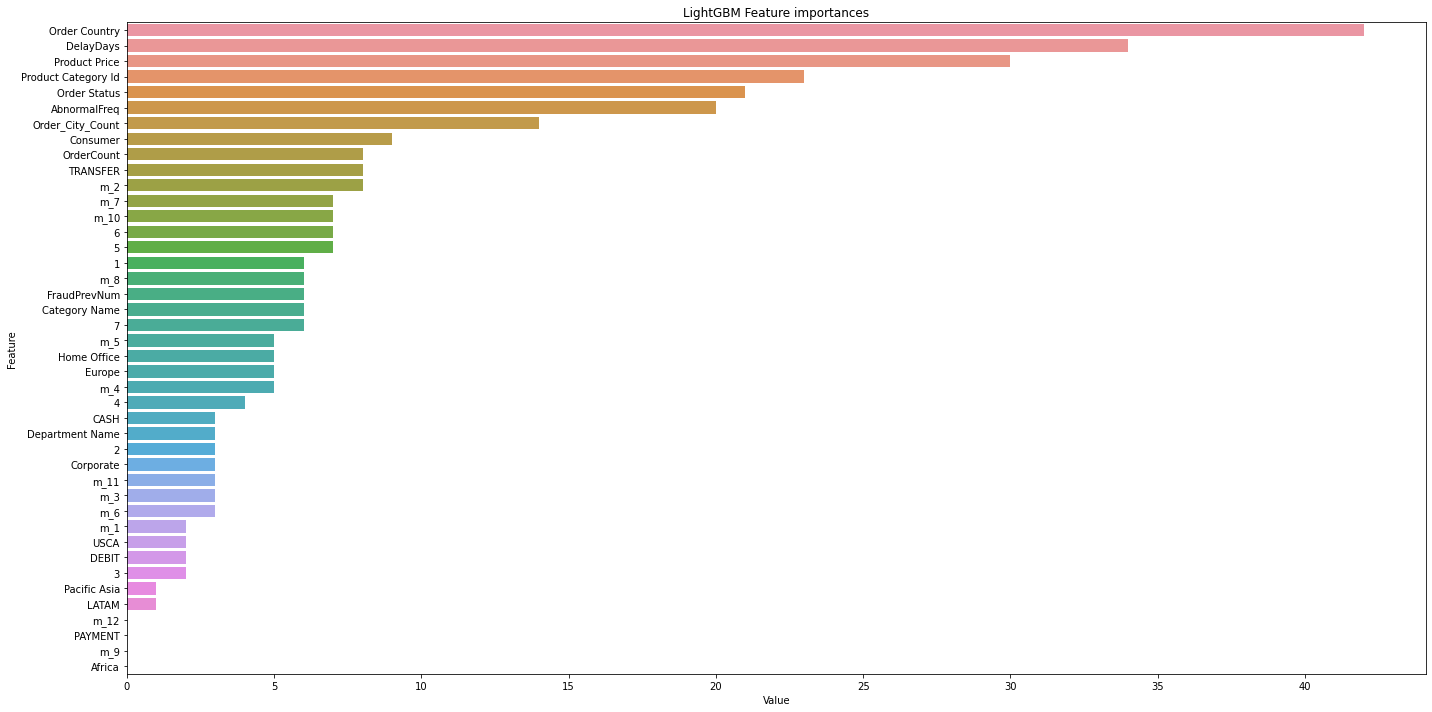

<Figure size 432x288 with 0 Axes>

In [55]:
features = ['Order Country',
       'Order Status',
       'Department Name',
       'Product Category Id', 'Product Price', 'Category Name',
       'Order_City_Count', 'FraudPrevNum',
       'AbnormalFreq', 'OrderCount', 'DelayDays', 'CASH', 'DEBIT', 'PAYMENT',
       'TRANSFER', 'Consumer', 'Corporate', 'Home Office', 'Africa',
       'Europe', 'LATAM', 'Pacific Asia', 'USCA', '1', '2', '3', '4', '5', '6',
       '7', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9',
       'm_10', 'm_11', 'm_12']

X = df[features]
y = df['Order Profit']

for i in X.columns:
    if X[i].dtype == 'object':
        X[i] = X[i].astype('category')

le = preprocessing.LabelEncoder()
#X['Order City']  = le.fit_transform(X['Order City'])
X['Category Name']  = le.fit_transform(X['Category Name'])
#X['Customer State'] = le.fit_transform(X['Customer State'])
#X['Customer Country']  = le.fit_transform(X['Customer Country'])
#X['Customer City']  = le.fit_transform(X['Customer City'])
X['Department Name']  = le.fit_transform(X['Department Name'])
X['Order Status']  = le.fit_transform(X['Order Status'])
#X['Order State']  = le.fit_transform(X['Order State'])
#X['Order Region']  = le.fit_transform(X['Order Region'])
X['Order Country']  = le.fit_transform(X['Order Country'])

thr = int(0.8 * len(X))
train_x, test_x = X[:thr], X[thr:]
train_y, test_y = y[:thr], y[thr:]

for i in X.columns:
    if X[i].dtype == 'object':
        X[i] = X[i].astype('category')

sc = MinMaxScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.fit_transform(test_x)
train_x = pd.DataFrame(train_x)
train_y = pd.DataFrame(train_y)

model = LGBMRegressor()
kf = KFold(n_splits=5, shuffle=False)
for train_index, test_index in kf.split(train_x, train_y):
    print("###")
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[test_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[test_index]
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=20)
    
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature importances')
plt.tight_layout()
plt.show()
plt.savefig("delay_days_profit.svg")

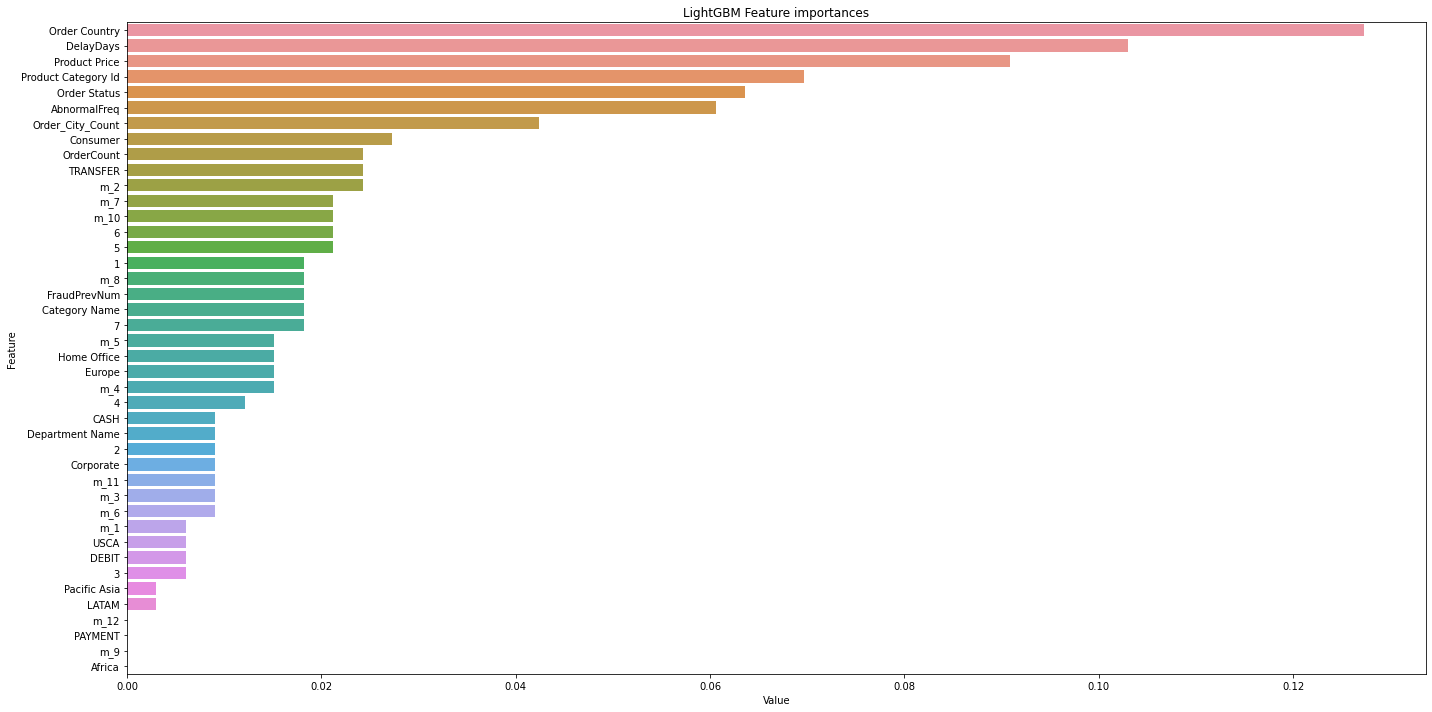

In [56]:
feature_imp['Value'] = feature_imp['Value'] / feature_imp['Value'].sum()
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature importances')
plt.tight_layout()
#plt.savefig("delay_days_profit_normalized.svg")
plt.show()

# Target: delay days, fraud-related features explain it well

###
[1]	valid_0's binary_logloss: 0.682976
[2]	valid_0's binary_logloss: 0.683129
[3]	valid_0's binary_logloss: 0.683101
[4]	valid_0's binary_logloss: 0.683207
[5]	valid_0's binary_logloss: 0.683263
[6]	valid_0's binary_logloss: 0.683269
[7]	valid_0's binary_logloss: 0.683306
[8]	valid_0's binary_logloss: 0.683317
[9]	valid_0's binary_logloss: 0.683167
[10]	valid_0's binary_logloss: 0.683166
[11]	valid_0's binary_logloss: 0.683202
[12]	valid_0's binary_logloss: 0.6832
[13]	valid_0's binary_logloss: 0.683226
[14]	valid_0's binary_logloss: 0.683371
[15]	valid_0's binary_logloss: 0.683365
[16]	valid_0's binary_logloss: 0.683386
[17]	valid_0's binary_logloss: 0.683518
[18]	valid_0's binary_logloss: 0.683617
[19]	valid_0's binary_logloss: 0.683682
[20]	valid_0's binary_logloss: 0.68373
[21]	valid_0's binary_logloss: 0.683729
###
[1]	valid_0's binary_logloss: 0.681358
[2]	valid_0's binary_logloss: 0.681578
[3]	valid_0's binary_logloss: 0.681833
[4]	valid_0's binary_logloss: 0.681842
[5]	vali

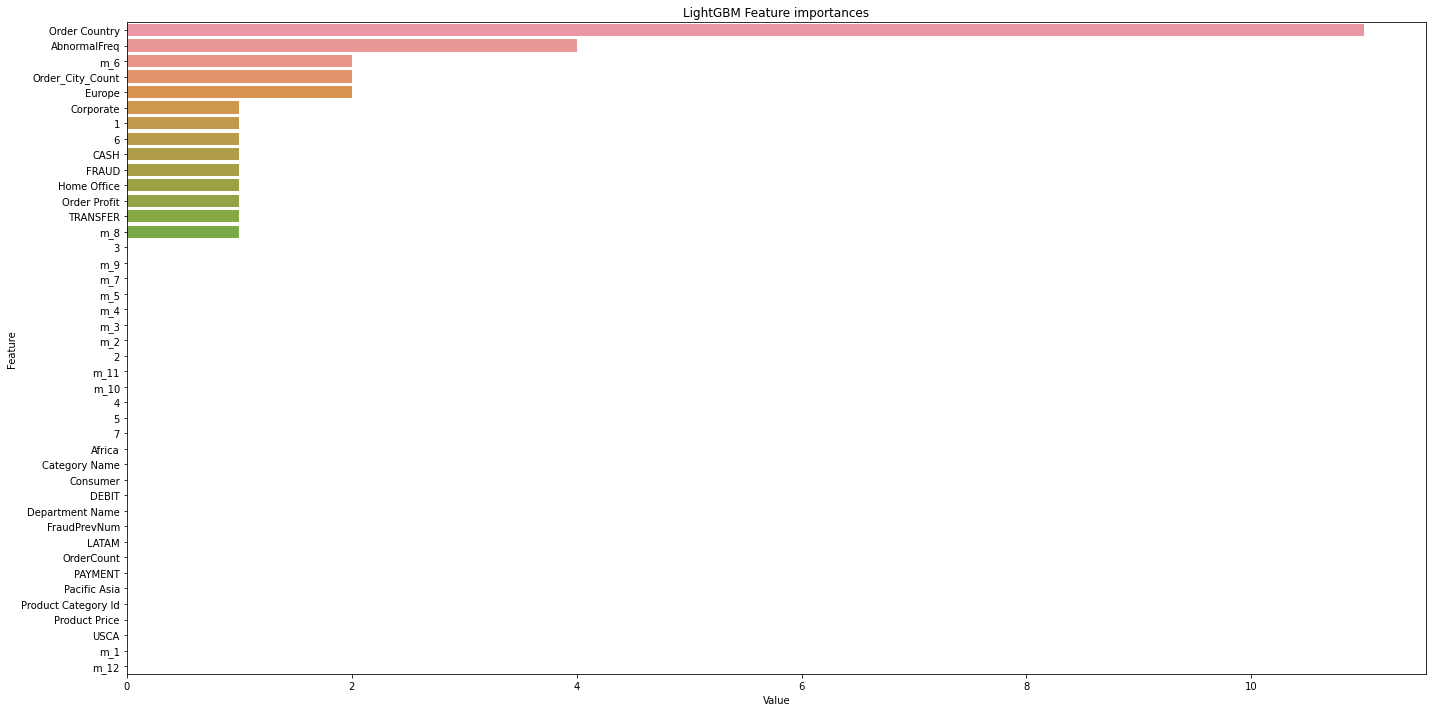

In [57]:
features2 = ['Order Country',
       'Order Status', 'Order Profit',
       'Department Name',
       'Product Category Id', 'Product Price', 'Category Name',
       'Order_City_Count', 'FraudPrevNum',
       'AbnormalFreq', 'OrderCount', 'CASH', 'DEBIT', 'PAYMENT',
       'TRANSFER', 'Consumer', 'Corporate', 'Home Office', 'Africa',
       'Europe', 'LATAM', 'Pacific Asia', 'USCA', '1', '2', '3', '4', '5', '6',
       '7', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9',
       'm_10', 'm_11', 'm_12']

X = df[features2]
y = df['DelayDays']
for i in range(len(y)):
    if y[i] <= 0:
        y[i] = 0
    else:
        y[i] = 1

X['FRAUD'] = X['Order Status']
X.loc[X['Order Status'] != 'SUSPECTED_FRAUD', 'FRAUD'] = 0
X.loc[X['Order Status'] == 'SUSPECTED_FRAUD', 'FRAUD'] = 1
X.drop(columns=['Order Status'], inplace=True)

le = preprocessing.LabelEncoder()
#X['Order City']  = le.fit_transform(X['Order City'])
X['Category Name']  = le.fit_transform(X['Category Name'])
#X['Customer State'] = le.fit_transform(X['Customer State'])
#X['Customer Country']  = le.fit_transform(X['Customer Country'])
#X['Customer City']  = le.fit_transform(X['Customer City'])
X['Department Name']  = le.fit_transform(X['Department Name'])
#X['Order Status']  = le.fit_transform(X['Order Status'])
#X['Order State']  = le.fit_transform(X['Order State'])
#X['Order Region']  = le.fit_transform(X['Order Region'])
X['Order Country']  = le.fit_transform(X['Order Country'])

X['FRAUD'] = X['FRAUD'].astype('category')

thr = int(0.8 * len(X))
train_x, test_x = X[:thr], X[thr:]
train_y, test_y = y[:thr], y[thr:]



# sc = StandardScaler()
# train_x = sc.fit_transform(train_x)
# test_x = sc.fit_transform(test_x)
# train_x = pd.DataFrame(train_x)
# train_y = pd.DataFrame(train_y)



model = LGBMClassifier()
kf = KFold(n_splits=5, shuffle=False)
for train_index, test_index in kf.split(train_x, train_y):
    print("###")
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[test_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[test_index]
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=20)
    
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature importances')
plt.tight_layout()
plt.show()

Proportion of rows of dataset considered fraud

In [58]:
len(X[X['FRAUD'] == 1]) / len(X)

0.022533623548176264

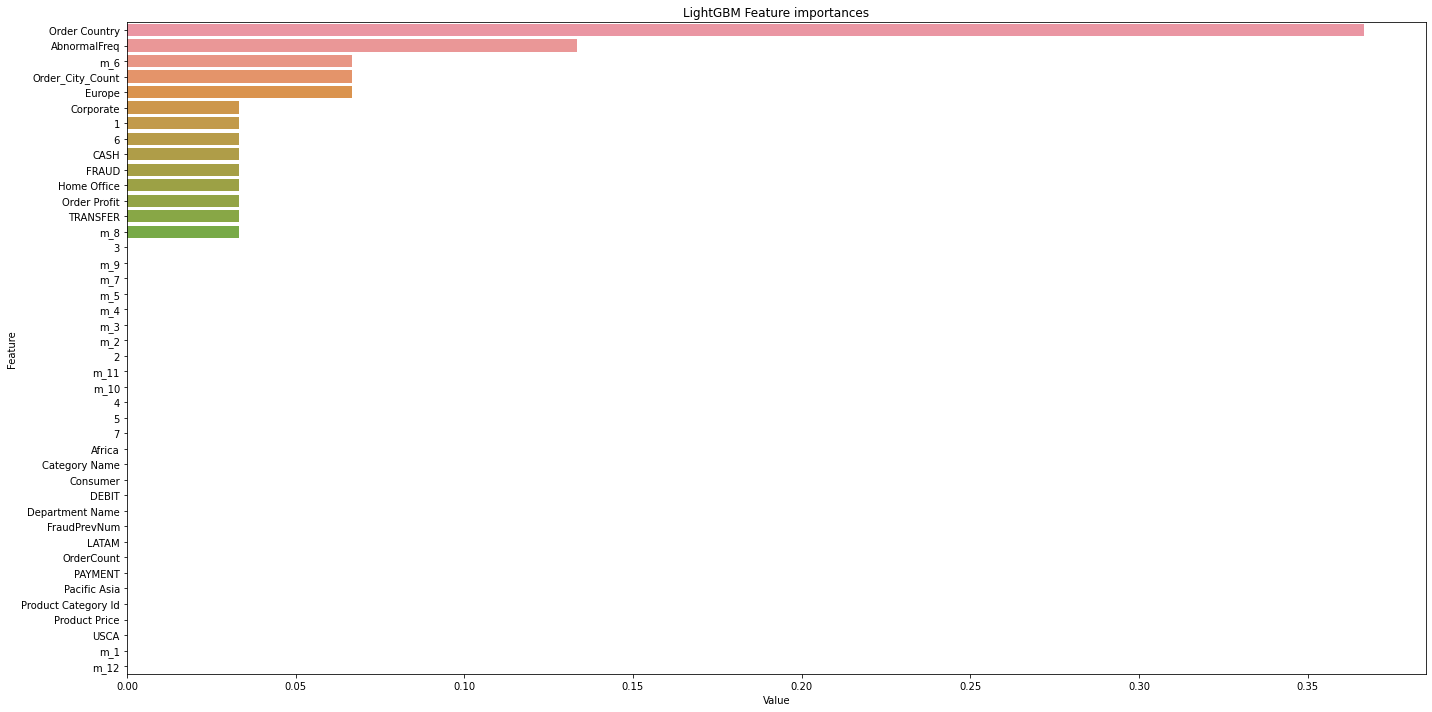

In [59]:
feature_imp['Value'] = feature_imp['Value'] / feature_imp['Value'].sum()
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature importances')
plt.tight_layout()
#plt.savefig("fraud_delay_days.svg")
plt.show()

# Target fraud, see what are the feature importances

In [61]:
features3 = ['Order Country',
       'Department Name', 'Depart_Latitude',
       'Depart_Longitude',
       'Product Category Id', 'Product Price', 'Category Name',
       'Order_City_Count', 'FraudPrevNum',
       'OrderCount', 'CASH', 'DEBIT', 'PAYMENT',
       'TRANSFER', 'Consumer', 'Corporate', 'Home Office', 'Africa',
       'Europe', 'LATAM', 'Pacific Asia', 'USCA', '1', '2', '3', '4', '5', '6',
       '7', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9',
       'm_10', 'm_11', 'm_12']

X = df[features3]
#X['Order Status'] = X['Order Status'].astype('category')
        
df['FRAUD'] = df['Order Status']
df.loc[df['Order Status'] != 'SUSPECTED_FRAUD', 'FRAUD'] = 0
df.loc[df['Order Status'] == 'SUSPECTED_FRAUD', 'FRAUD'] = 1
df.drop(columns=['Order Status'], inplace=True)
y= df['FRAUD']
y = y.astype('int')


sm = SMOTE(random_state=0)
X, y = sm.fit_resample(X, y)


le = preprocessing.LabelEncoder()
#X['Order City']  = le.fit_transform(X['Order City'])
X['Category Name']  = le.fit_transform(X['Category Name'])
#X['Customer State'] = le.fit_transform(X['Customer State'])
#X['Customer Country']  = le.fit_transform(X['Customer Country'])
#X['Customer City']  = le.fit_transform(X['Customer City'])
X['Department Name']  = le.fit_transform(X['Department Name'])
#X['Order Status']  = le.fit_transform(X['Order Status'])
#X['Order State']  = le.fit_transform(X['Order State'])
#X['Order Region']  = le.fit_transform(X['Order Region'])
X['Order Country']  = le.fit_transform(X['Order Country'])

thr = int(0.5 * len(X))
# train_x, test_x = X[:thr], X[thr:]
# train_y, test_y = y[:thr], y[thr:]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

sc = StandardScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.fit_transform(test_x)
train_x = pd.DataFrame(train_x)
train_y = pd.DataFrame(train_y)

model = LGBMClassifier()
kf = KFold(n_splits=5, shuffle=False)
for train_index, test_index in kf.split(train_x, train_y):
    print("###")
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[test_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[test_index]
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
            early_stopping_rounds=20)
    
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature importances')
plt.tight_layout()
plt.show()

KeyError: 'Order Status'

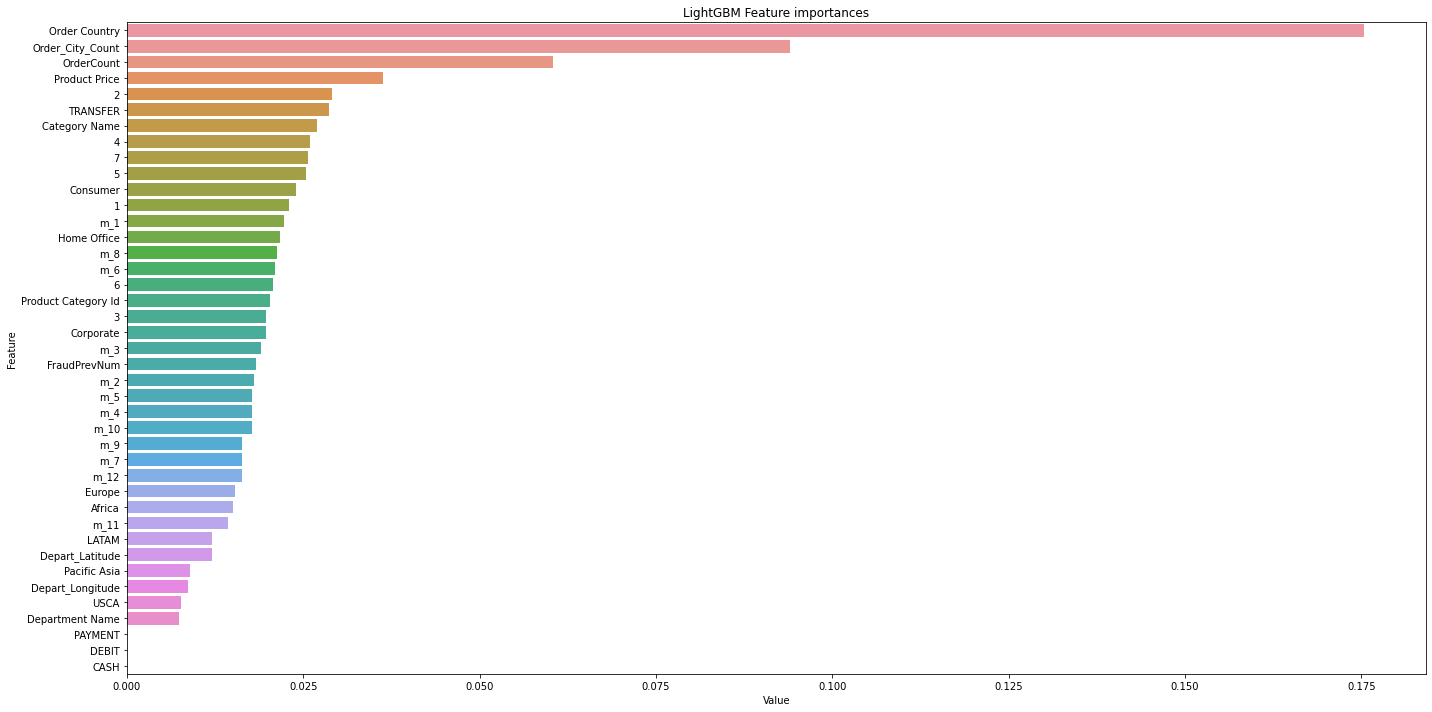

In [94]:
feature_imp['Value'] = feature_imp['Value'] / feature_imp['Value'].sum()
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature importances')
plt.tight_layout()
plt.savefig("others_fraud.svg")
plt.show()

# DelayDays and FRAUD: models similar to kaggle kernel

### Add smote to fraud

###
[1]	valid_0's binary_logloss: 0.101445
[2]	valid_0's binary_logloss: 0.0981716
[3]	valid_0's binary_logloss: 0.0954403
[4]	valid_0's binary_logloss: 0.0936735
[5]	valid_0's binary_logloss: 0.0919713
[6]	valid_0's binary_logloss: 0.0902251
[7]	valid_0's binary_logloss: 0.0888958
[8]	valid_0's binary_logloss: 0.0879903
[9]	valid_0's binary_logloss: 0.0871325
[10]	valid_0's binary_logloss: 0.0863319
[11]	valid_0's binary_logloss: 0.08568
[12]	valid_0's binary_logloss: 0.0850656
[13]	valid_0's binary_logloss: 0.0844859
[14]	valid_0's binary_logloss: 0.0841555
[15]	valid_0's binary_logloss: 0.083725
[16]	valid_0's binary_logloss: 0.0834467
[17]	valid_0's binary_logloss: 0.0832082
[18]	valid_0's binary_logloss: 0.0828549
[19]	valid_0's binary_logloss: 0.0825351
[20]	valid_0's binary_logloss: 0.0823853
[21]	valid_0's binary_logloss: 0.0822243
[22]	valid_0's binary_logloss: 0.0817716
[23]	valid_0's binary_logloss: 0.0816502
[24]	valid_0's binary_logloss: 0.0815065
[25]	valid_0's binary_log

[38]	valid_0's binary_logloss: 0.0788204
[39]	valid_0's binary_logloss: 0.0788814
[40]	valid_0's binary_logloss: 0.0788778
[41]	valid_0's binary_logloss: 0.0788649
[42]	valid_0's binary_logloss: 0.0788368
[43]	valid_0's binary_logloss: 0.0788236
[44]	valid_0's binary_logloss: 0.0788521
[45]	valid_0's binary_logloss: 0.078854
[46]	valid_0's binary_logloss: 0.0788522
[47]	valid_0's binary_logloss: 0.0788705
[48]	valid_0's binary_logloss: 0.0789092
[49]	valid_0's binary_logloss: 0.0791012
[50]	valid_0's binary_logloss: 0.0791133
###
[1]	valid_0's binary_logloss: 0.108189
[2]	valid_0's binary_logloss: 0.104021
[3]	valid_0's binary_logloss: 0.101526
[4]	valid_0's binary_logloss: 0.0994177
[5]	valid_0's binary_logloss: 0.0975204
[6]	valid_0's binary_logloss: 0.0964275
[7]	valid_0's binary_logloss: 0.0952104
[8]	valid_0's binary_logloss: 0.0941706
[9]	valid_0's binary_logloss: 0.0934324
[10]	valid_0's binary_logloss: 0.0926344
[11]	valid_0's binary_logloss: 0.0918673
[12]	valid_0's binary_log

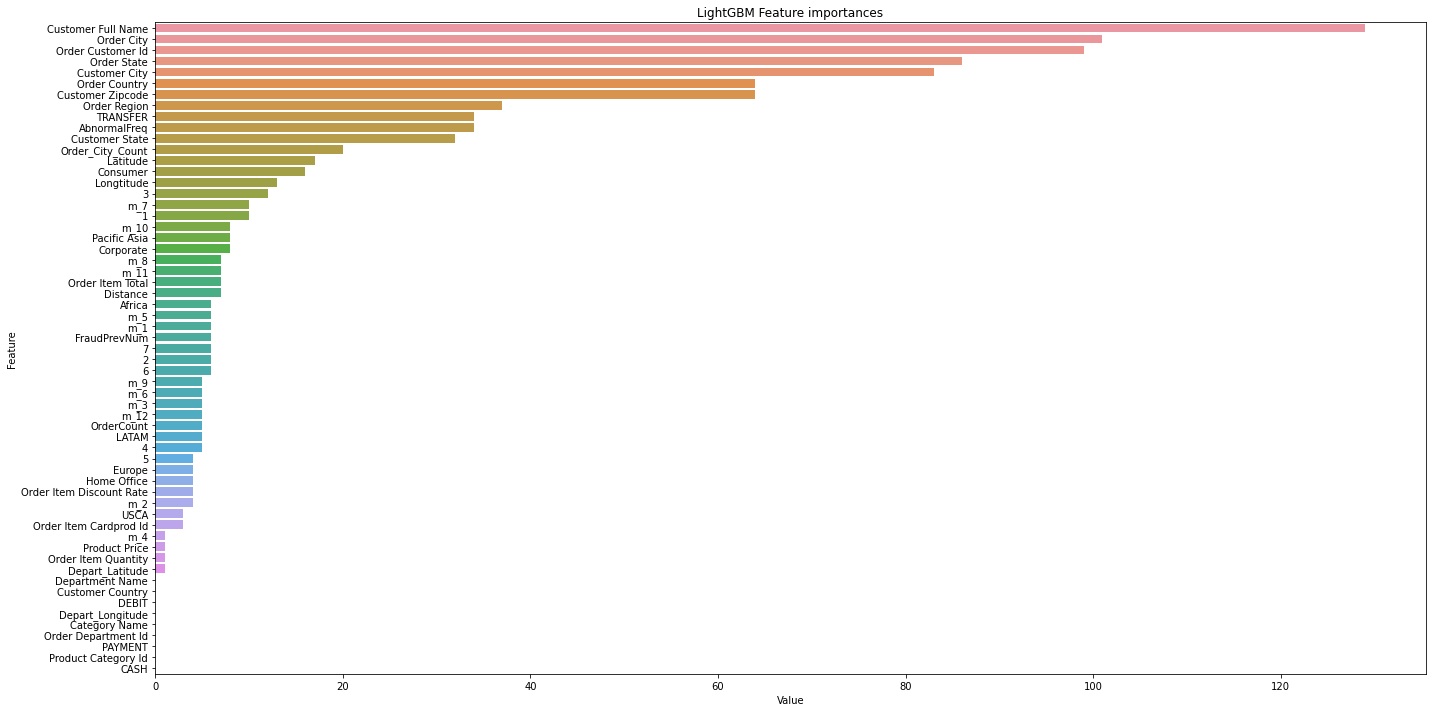

In [156]:
# features_d = ['Order Country',
#        'Order Status',
#        'Department Name', 'Depart_Latitude',
#        'Depart_Longitude',
#        'Product Category Id', 'Product Price', 'Category Name',
#        'Order_City_Count', 'FraudPrevNum',
#        'AbnormalFreq', 'OrderCount', 'CASH', 'DEBIT', 'PAYMENT',
#        'TRANSFER', 'Consumer', 'Corporate', 'Home Office', 'Africa',
#        'Europe', 'LATAM', 'Pacific Asia', 'USCA', '1', '2', '3', '4', '5', '6',
#        '7', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9',
#        'm_10', 'm_11', 'm_12']


features_d = ['Order Item Cardprod Id', 'Order Customer Id',
       'Order Department Id', 'Order City', 'Order Country', 'Order Region',
       'Order State', 'Order Item Discount Rate',
       'Order Item Quantity', 'Order Item Total',
       'Department Name', 'Depart_Latitude',
       'Depart_Longitude', 'Customer City', 'Customer Country',
       'Customer State', 'Customer Zipcode', 'Customer Full Name',
       'Product Category Id', 'Product Price', 'Category Name', 'Latitude',
       'Longtitude', 'Distance', 'Order_City_Count',
       'AbnormalFreq', 'OrderCount', 'CASH', 'DEBIT', 'PAYMENT',
       'TRANSFER', 'Consumer', 'Corporate', 'Home Office', 'Africa',
       'Europe', 'LATAM', 'Pacific Asia', 'USCA', '1', '2', '3', '4', '5', '6',
       '7', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9',
       'm_10', 'm_11', 'm_12']

features_f = ['Order Item Cardprod Id', 'Order Customer Id',
       'Order Department Id', 'Order City', 'Order Country', 'Order Region',
       'Order State', 'Order Item Discount Rate',
       'Order Item Quantity', 'Order Item Total',
       'Department Name', 'Depart_Latitude',
       'Depart_Longitude', 'Customer City', 'Customer Country',
       'Customer State', 'Customer Zipcode', 'Customer Full Name',
       'Product Category Id', 'Product Price', 'Category Name', 'Latitude',
       'Longtitude', 'Distance', 'Order_City_Count',
       'AbnormalFreq', 'OrderCount', 'CASH', 'DEBIT', 'PAYMENT',
       'TRANSFER', 'Consumer', 'Corporate', 'Home Office', 'Africa',
       'Europe', 'LATAM', 'Pacific Asia', 'USCA', '1', '2', '3', '4', '5', '6',
       '7', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9',
       'm_10', 'm_11', 'm_12', 'FraudPrevNum']

# features_f = ['Order Country',
#        'Department Name', 'Depart_Latitude',
#        'Depart_Longitude',
#        'Product Category Id', 'Product Price', 'Category Name',
#        'Order_City_Count',
#        'OrderCount', 'CASH', 'DEBIT', 'PAYMENT',
#        'TRANSFER', 'Consumer', 'Corporate', 'Home Office', 'Africa',
#        'Europe', 'LATAM', 'Pacific Asia', 'USCA', '1', '2', '3', '4', '5', '6',
#        '7', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9',
#        'm_10', 'm_11', 'm_12']

Xd = df[features_d]
yd = df['DelayDays']

# Xd['FRAUD'] = Xd['Order Status']
# Xd.loc[Xd['Order Status'] != 'SUSPECTED_FRAUD', 'FRAUD'] = 0
# Xd.loc[Xd['Order Status'] == 'SUSPECTED_FRAUD', 'FRAUD'] = 1
# Xd.drop(columns=['Order Status'], inplace=True)

for i in range(len(yd)):
    if yd[i] <= 0:
        yd[i] = 0
    else:
        yd[i] = 1

thr = int(0.8 * len(Xd))
train_xd, test_xd = Xd[:thr], Xd[thr:]
train_yd, test_yd = yd[:thr], yd[thr:]

Xf = df[features_f]

df['FRAUD'] = df['Order Status']
df.loc[df['Order Status'] != 'SUSPECTED_FRAUD', 'FRAUD'] = 0
df.loc[df['Order Status'] == 'SUSPECTED_FRAUD', 'FRAUD'] = 1
df.drop(columns=['Order Status'], inplace=True)
yf = df['FRAUD']
yf = yf.astype('int')

sm = SMOTE(random_state=0)
train_xf, train_yf = sm.fit_resample(Xf[:thr], yf[:thr])
test_xf, test_yf = Xf[thr:], yf[thr:]

# train_xf, train_yf = Xf[:thr], yf[:thr]
# test_xf, test_yf = Xf[thr:], yf[thr:]

sc = StandardScaler()
train_xd=sc.fit_transform(train_xd)
test_xd=sc.transform(test_xd)
train_xf=sc.fit_transform(train_xf)
test_xf=sc.transform(test_xf)

# model = LGBMClassifier()
# kf = KFold(n_splits=5, shuffle=False)
# for train_index, test_index in kf.split(Xf, yf):
#     print("###")
#     X_train, X_val = Xf.iloc[train_index], Xf.iloc[test_index]
#     y_train, y_val = yf.iloc[train_index], yf.iloc[test_index]
#     model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
#             early_stopping_rounds=20)
    
# # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
# feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,Xf.columns)), columns=['Value','Feature'])

# plt.figure(figsize=(20, 10))
# sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
# plt.title('LightGBM Feature importances')
# plt.tight_layout()
# plt.show()

train_yd = train_yd.astype('int')
train_yf = train_yf.astype('int')
test_yd = test_yd.astype('int')
test_yd = test_yd.astype('int')

def classifiermodel(model_d,model_f, train_xd, test_xd, train_yd, test_yd,
                                     train_xf, test_xf, train_yf, test_yf):
    model_d=model_d.fit(train_xd,train_yd) 
    model_f=model_f.fit(train_xf,train_yf) 
    yd_pred=model_d.predict(test_xd)
    yf_pred=model_f.predict(test_xf)  
    accuracy_d=accuracy_score(yd_pred, test_yd) #Accuracy for fraud detection
    accuracy_f=accuracy_score(yf_pred, test_yf) #Accuracy for predection of late delivery
    recall_d=recall_score(yd_pred, test_yd) #Recall score for  fraud detection
    recall_f=recall_score(yf_pred, test_yf)# Recall score for predection of late delivery
    conf_d=confusion_matrix(yd_pred, test_yd)# fraud detection
    conf_f=confusion_matrix(yf_pred, test_yf)#predection of late delivery
    f1_d=f1_score(test_yd, yd_pred)#fraud detection
    f1_f=f1_score(test_yf, yf_pred)#predection of late delivery
    print('Model paramters used are :',model_d)
    print('Accuracy of delay days is        :', (accuracy_d)*100,'%')
    print('Recall score of delay days is        :', (recall_d)*100,'%')
    print('Conf Matrix of delay days is        :\n',  (conf_d))
    print('F1 score of delay days is        :', (f1_d)*100,'%')
    print('Accuracy of fraud is:', (accuracy_f)*100,'%')
    print('Recall score of fraud is:', (recall_f)*100,'%')
    print('Conf Matrix of fraud is: \n',(conf_f))
    print('F1 score of fraud is:', (f1_f)*100,'%')

In [153]:
%%time
model_d = LogisticRegression(solver='lbfgs',random_state=0) #the classification model
model_f = LogisticRegression(solver='lbfgs',random_state=0) #the classification model
#Giving inputs to the defined function
classifiermodel(model_d,model_f,train_xd, test_xd, train_yd, test_yd, train_xf, test_xf, train_yf, test_yf)

Model paramters used are : LogisticRegression(random_state=0)
Accuracy of delay days is        : 57.18782791185729 %
Recall score of delay days is        : 57.18782791185729 %
Conf Matrix of delay days is        :
 [[    0     0]
 [14280 19075]]
F1 score of delay days is        : 72.76368491321762 %
Accuracy of fraud is: 90.31929245990106 %
Recall score of fraud is: 8.221070811744386 %
Conf Matrix of fraud is: 
 [[29888   572]
 [ 2657   238]]
F1 score of fraud is: 12.847503373819164 %
CPU times: user 14 s, sys: 918 ms, total: 14.9 s
Wall time: 3.77 s


In [116]:
test_yf.value_counts()

0    32545
1      810
Name: FRAUD, dtype: int64

In [102]:
%%time
model_d = ExtraTreesClassifier(n_estimators=100, max_depth=None,random_state=0)
model_f = ExtraTreesClassifier(n_estimators=100, max_depth=None,random_state=0)
classifiermodel(model_d,model_f,train_xd, test_xd, train_yd, test_yd, train_xf, test_xf, train_yf, test_yf)

Model paramters used are : ExtraTreesClassifier(random_state=0)
Accuracy of delay days is        : 54.870334282716236 %
Recall score of delay days is        : 57.35122093873374 %
Conf Matrix of delay days is        :
 [[ 2613  3386]
 [11667 15689]]
F1 score of delay days is        : 67.57984966940192 %
Accuracy of fraud is: 97.5595862689252 %
Recall score of fraud is: 25.0 %
Conf Matrix of fraud is: 
 [[32539   808]
 [    6     2]]
F1 score of fraud is: 0.48899755501222486 %
CPU times: user 47.8 s, sys: 477 ms, total: 48.3 s
Wall time: 48.3 s


In [103]:
%%time
model_d = xgb.XGBClassifier()
model_f = xgb.XGBClassifier()
classifiermodel(model_d,model_f,train_xd, test_xd, train_yd, test_yd, train_xf, test_xf, train_yf, test_yf)

[16:42:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model paramters used are : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel

In [136]:
%%time
model_d = tree.DecisionTreeClassifier()
model_f = tree.DecisionTreeClassifier()
classifiermodel(model_d,model_f,train_xd, test_xd, train_yd, test_yd, train_xf, test_xf, train_yf, test_yf)

Model paramters used are : DecisionTreeClassifier()
Accuracy of delay days is        : 51.78234147803927 %
Recall score of delay days is        : 57.90948503753833 %
Conf Matrix of delay days is        :
 [[ 6319  8122]
 [ 7961 10953]]
F1 score of delay days is        : 57.66406064913527 %
Accuracy of fraud is: 94.69644730924898 %
Recall score of fraud is: 9.671993271656856 %
Conf Matrix of fraud is: 
 [[31471   695]
 [ 1074   115]]
F1 score of fraud is: 11.505752876438219 %
CPU times: user 5.07 s, sys: 21.1 ms, total: 5.09 s
Wall time: 5.09 s


In [137]:
%%time
model_d = svm.LinearSVC()
model_f = svm.LinearSVC()
classifiermodel(model_d,model_f,train_xd, test_xd, train_yd, test_yd, train_xf, test_xf, train_yf, test_yf)

Model paramters used are : LinearSVC()
Accuracy of delay days is        : 57.18782791185729 %
Recall score of delay days is        : 57.18782791185729 %
Conf Matrix of delay days is        :
 [[    0     0]
 [14280 19075]]
F1 score of delay days is        : 72.76368491321762 %
Accuracy of fraud is: 97.5715784739919 %
Recall score of fraud is: 0.0 %
Conf Matrix of fraud is: 
 [[32545   810]
 [    0     0]]
F1 score of fraud is: 0.0 %
CPU times: user 1min 15s, sys: 147 ms, total: 1min 15s
Wall time: 1min 15s


In [144]:
%%time
model_d = GaussianNB()
model_f = GaussianNB()
classifiermodel(model_d,model_f,train_xd, test_xd, train_yd, test_yd, train_xf, test_xf, train_yf, test_yf)

Model paramters used are : GaussianNB()
Accuracy of delay days is        : 57.214810373257386 %
Recall score of delay days is        : 57.31514191740772 %
Conf Matrix of delay days is        :
 [[  264   255]
 [14016 18820]]
F1 score of delay days is        : 72.50871684228775 %
Accuracy of fraud is: 73.64712936591215 %
Recall score of fraud is: 8.4375 %
Conf Matrix of fraud is: 
 [[23755     0]
 [ 8790   810]]
F1 score of fraud is: 15.561959654178676 %
CPU times: user 311 ms, sys: 105 ms, total: 416 ms
Wall time: 414 ms


In [107]:
%%time
model_d = RandomForestClassifier()
model_f = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
classifiermodel(model_d,model_f,train_xd, test_xd, train_yd, test_yd, train_xf, test_xf, train_yf, test_yf)

Model paramters used are : RandomForestClassifier()
Accuracy of delay days is        : 55.81771848298606 %
Recall score of delay days is        : 57.77140809745611 %
Conf Matrix of delay days is        :
 [[ 2494  2951]
 [11786 16124]]
F1 score of delay days is        : 68.63467063956583 %
Accuracy of fraud is: 90.69105081696897 %
Recall score of fraud is: 8.105147864184008 %
Conf Matrix of fraud is: 
 [[30028   588]
 [ 2517   222]]
F1 score of fraud is: 12.510566356720204 %
CPU times: user 1min 12s, sys: 321 ms, total: 1min 12s
Wall time: 1min 12s


In [123]:
classification_data = {'Classification Model':  ['Logistic','Extra Trees','XGB','Decision Tree',
                                'SVM','Gaussian Naive Bayes','Random Forest'],   
        'Accuracy Score for Fraud Detection':       [72.76, 22.76, 17.93, 29.25, 16.89, 95.43, 16.89],
        'Recall Score for Fraud Detection':         [0, 98.49, 95.11, 95.98, 0, 94.79, 0],
        'F1 Score for Fraud Detection':             [0, 13.36, 2.35, 26.75, 0, 97.32, 0],
        'Number of False Negatives': [569, 808, 805, 688, 567, 0, 588]}
#Creating data frame with Column Names
classification_comparision = pd.DataFrame (classification_data, columns = ['Classification Model',
                                                                           'Accuracy Score for Fraud Detection','Recall Score for Fraud Detection','F1 Score for Fraud Detection',
                                                                           'Number of False Negatives'])

## Write in report

In [98]:
import dataframe_image as dfi
dfi.export(classification_comparision, 'models.png')

In [124]:
print(classification_comparision.to_latex())

\begin{tabular}{llrrrr}
\toprule
{} &  Classification Model &  Accuracy Score for Fraud Detection &  Recall Score for Fraud Detection &  F1 Score for Fraud Detection &  Number of False Negatives \\
\midrule
0 &              Logistic &                               72.76 &                              0.00 &                          0.00 &                        569 \\
1 &           Extra Trees &                               22.76 &                             98.49 &                         13.36 &                        808 \\
2 &                   XGB &                               17.93 &                             95.11 &                          2.35 &                        805 \\
3 &         Decision Tree &                               29.25 &                             95.98 &                         26.75 &                        688 \\
4 &                   SVM &                               16.89 &                              0.00 &                          0.00 &    

In [ ]:
#!jupyter nbconvert --to html .ipynb

In [139]:
df.columns

Index(['Date', 'index', 'Order Item Cardprod Id', 'Order Customer Id',
       'Order Department Id', 'Order City', 'Order Country', 'Order Region',
       'Order State', 'Order Item Discount Rate', 'Order Item Quantity',
       'Order Item Total', 'Order Profit', 'Days for shipping (real)',
       'Days for shipment (scheduled)', 'Late Delivery Risk',
       'Department Name', 'Depart_Latitude', 'Depart_Longitude',
       'Customer City', 'Customer Country', 'Customer State',
       'Customer Zipcode', 'Customer Full Name', 'Product Category Id',
       'Product Price', 'Category Name', 'Latitude', 'Longtitude', 'Distance',
       'Order_City_Count', 'FraudPrevNum', 'AbnormalFreq', 'OrderCount',
       'DelayDays', 'CASH', 'DEBIT', 'PAYMENT', 'TRANSFER', 'Advance shipping',
       'Late delivery', 'Shipping canceled', 'Shipping on time', 'Consumer',
       'Corporate', 'Home Office', 'Africa', 'Europe', 'LATAM', 'Pacific Asia',
       'USCA', '1', '2', '3', '4', '5', '6', '7', 'm_1', '